In [49]:
# made by Gibeom LEE, HI LAB
# VPP finder랑 똑같은데, 그냥 전류 버전

In [50]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [51]:
# 폴더 경로
folder_path = r"G:\다른 컴퓨터\KHU PC\HI Lab\0. Projects\0. On going\2. Aloe inspired DEG\0. 실험자료\4. Data measurement\250908_전극모양\csv파일\FEP전류_100uAV"

# 사용자 설정값
prominence_ratio = 0.3 # 신호의 표준편차(std)에 곱해 피크 prominence 기준을 설정 / 주변 값보다 얼마나 돌출된 정도여야 피크로 인식할지를 결정
min_prominence = 0.1 # prominence의 최솟값 제한 / std가 너무 작아서 prominence가 너무 낮게 계산되는 경우를 방지
min_distance_sec = 0.15 #인접한 피크 간 최소 시간 간격 (초 단위)
snr_threshold = 0.1 # Signal-to-Noise Ratio 기준값 / 값이 높을수록 강한 피크만 통과
min_relative_height = 0.1 # 전체 최대 진폭설정 ex) 0.2: 20% 이상 

#그래프
y_range = (-300, 50)
Conv = 100 # unit: uA/V 

I100uAV_Flat_elec_2cm_Vpp: 200.53 V
I100uAV_Flat_elec_2cm_Peak number: 1개
I100uAV_Flat_elec_2cm_표준편차: 0.00
I100uAV_Flat_elec_2cm_주파수: 0.00 Hz


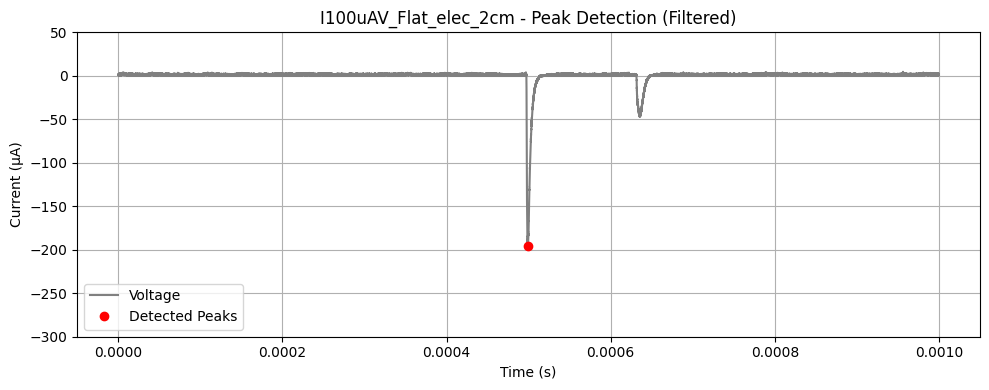

I100uAV_sharp_elec_3cm_Vpp: 224.52 V
I100uAV_sharp_elec_3cm_Peak number: 1개
I100uAV_sharp_elec_3cm_표준편차: 0.00
I100uAV_sharp_elec_3cm_주파수: 0.00 Hz


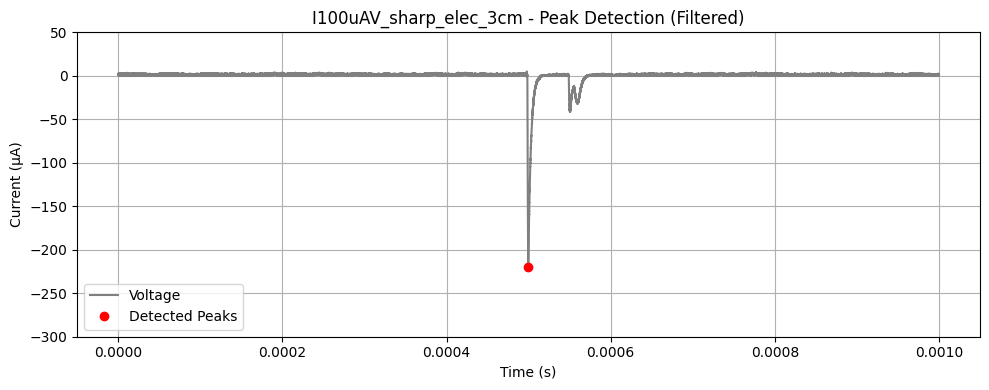

I100uAV_sharp_elec_1cm_Vpp: 256.66 V
I100uAV_sharp_elec_1cm_Peak number: 1개
I100uAV_sharp_elec_1cm_표준편차: 0.00
I100uAV_sharp_elec_1cm_주파수: 0.00 Hz


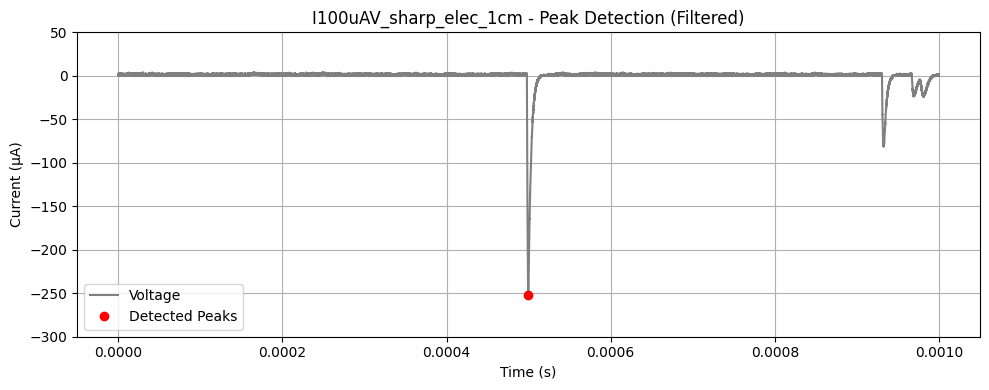

I100uAV_Flat_elec_5cm_Vpp: 217.80 V
I100uAV_Flat_elec_5cm_Peak number: 1개
I100uAV_Flat_elec_5cm_표준편차: 0.00
I100uAV_Flat_elec_5cm_주파수: 0.00 Hz


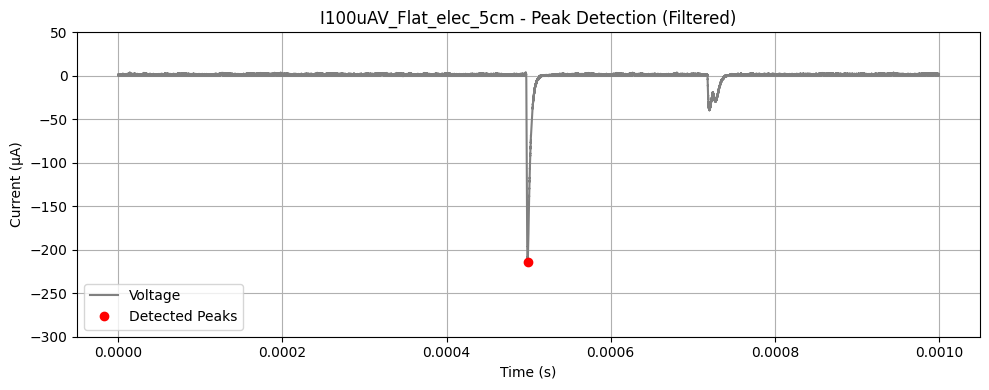

I100uAV_Flat_elec_1cm_Vpp: 164.23 V
I100uAV_Flat_elec_1cm_Peak number: 1개
I100uAV_Flat_elec_1cm_표준편차: 0.00
I100uAV_Flat_elec_1cm_주파수: 0.00 Hz


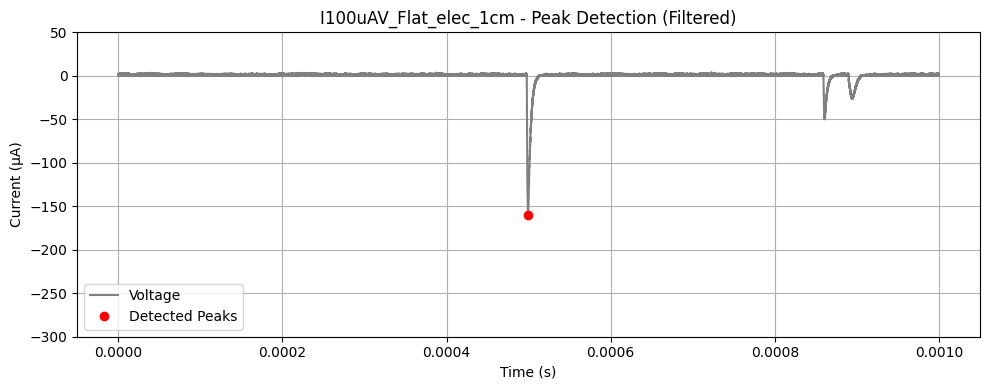


📊 모든 파일의 평균 Vpp, 표준편차, 평균 주파수 목록
I100uAV_Flat_elec_2cm.csv_Ipp: 200.53 µA | 표준편차: 0.00 µA | 주파수: 0.00 Hz
I100uAV_sharp_elec_3cm.csv_Ipp: 224.52 µA | 표준편차: 0.00 µA | 주파수: 0.00 Hz
I100uAV_sharp_elec_1cm.csv_Ipp: 256.66 µA | 표준편차: 0.00 µA | 주파수: 0.00 Hz
I100uAV_Flat_elec_5cm.csv_Ipp: 217.80 µA | 표준편차: 0.00 µA | 주파수: 0.00 Hz
I100uAV_Flat_elec_1cm.csv_Ipp: 164.23 µA | 표준편차: 0.00 µA | 주파수: 0.00 Hz

📈 전체 평균 Ipp: 212.75 µA
📉 표준편차 (Ipp): 33.89 µA
🎵 전체 평균 주파수: 0.00 Hz
🎯 표준편차 (주파수): 0.00 Hz


In [ ]:
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
all_vpp_values = []
file_std_values = []
all_freq_values = []  # 주파수 리스트 저장

# -------------------------------
# 파일별 처리
for file_name in csv_files:
    file_path = os.path.join(folder_path, file_name)
    try:
        # 데이터 로드
        df = pd.read_csv(file_path)
        time = df.iloc[:, 0].values
        current = Conv*df.iloc[:, 1].values

        # 샘플링 속도
        total_time = time[-1] - time[0]
        sampling_rate = len(time) / total_time
        distance = int(sampling_rate * min_distance_sec)

        # 피크 검출 (음의 피크 대상으로)
        prom = max(np.std(current) * prominence_ratio, min_prominence)
        raw_peaks, properties = find_peaks(-current, prominence=prom, distance=distance)

        # 피크 필터링
        max_amplitude = np.max(-current)
        final_peaks = []
        for i in raw_peaks:
            left = max(0, i - int(0.05 * sampling_rate))
            right = min(len(current), i + int(0.05 * sampling_rate))
            local_noise = max(np.std(current[left:right]), 1e-6)
            signal = -current[i]
            if signal > max_amplitude * min_relative_height and signal / local_noise > snr_threshold:
                final_peaks.append(i)

        final_peaks = np.array(final_peaks, dtype=int)
        peak_times = time[final_peaks]

        # Vpp 계산
        vpp_list = []
        if len(final_peaks) > 1:
            for i in range(len(final_peaks) - 1):
                start = final_peaks[i]
                end = final_peaks[i + 1]
                vpp = np.max(current[start:end + 1]) - np.min(current[start:end + 1])
                vpp_list.append(vpp)
        elif len(final_peaks) == 1:
            # 피크가 하나일 때 Vpp 계산
            vpp_list.append(np.max(current) - np.min(current))

        mean_vpp = np.mean(vpp_list) if vpp_list else 0
        std = np.std(vpp_list, ddof=1) if len(vpp_list) > 1 else 0  # 표준편차 계산

        # 주파수 계산
        if len(peak_times) < 2:
            mean_freq = 0
        else:
            periods = np.diff(peak_times)
            mean_freq = np.mean(1 / periods)

        # 결과 출력
        base_name = os.path.splitext(file_name)[0]
        print(f"{base_name}_Ipp: {mean_vpp:.2f} µA")
        print(f"{base_name}_Peak number: {len(vpp_list):.0f}개")
        print(f"{base_name}_표준편차: {std:.2f}")
        print(f"{base_name}_주파수: {mean_freq:.2f} Hz")

        # 결과 저장
        all_vpp_values.append(mean_vpp)
        file_std_values.append(std)
        all_freq_values.append(mean_freq)

        # -------------------------------
        # 그래프 출력
        plt.figure(figsize=(10, 4))
        plt.plot(time, current, color='gray', label='Current')
        if len(final_peaks) > 0:
            plt.plot(time[final_peaks], current[final_peaks], 'ro', label='Detected Peaks')
        plt.title(f"{base_name} - Peak Detection (Filtered)")
        plt.xlabel("Time (s)")
        plt.ylabel("Current (µA)")
        plt.ylim(y_range)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"{file_name} 처리 중 오류 발생: {e}")

# -------------------------------
# 전체 요약 출력
print("\n==============================")
print("📊 모든 파일의 평균 Vpp, 표준편차, 평균 주파수 목록")
for i in range(len(all_vpp_values)):
    print(f"{csv_files[i]}_Ipp: {all_vpp_values[i]:.2f} µA | 표준편차: {file_std_values[i]:.2f} µA | 주파수: {all_freq_values[i]:.2f} Hz")

if all_vpp_values:
    overall_mean_vpp = np.mean(all_vpp_values)
    overall_std_vpp = np.std(all_vpp_values, ddof=1)
    overall_mean_freq = np.mean(all_freq_values) if all_freq_values else 0
    overall_std_freq = np.std(all_freq_values, ddof=1) if all_freq_values else 0

    print("\n==============================")
    print(f"📈 전체 평균 Ipp: {overall_mean_vpp:.2f} µA")
    print(f"📉 표준편차 (Ipp): {overall_std_vpp:.2f} µA")
    print(f"🎵 전체 평균 주파수: {overall_mean_freq:.2f} Hz")
    print(f"🎯 표준편차 (주파수): {overall_std_freq:.2f} Hz")
else:
    print("📭 Vpp 데이터를 계산할 수 없습니다.")
